## Kerasによる銀河形態分類（Hubble系列4クラス）畳み込みニューラルネット  
### Chollet, F. (2018). *Deep Learning with Python.* Manning Publications Co. Chapter 5参照


In [1]:
import os, shutil
import sys, time
import keras
print(keras.__version__)

# 作業用ディレクトリ定義（要カスタマイズ）
galaxy_data_directory = '/home/satoshi/Galaxy/'

Using TensorFlow backend.


2.2.0


#### Keras Conv2Dモデル  input_shape;150

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

#### モデルのコンパイル

In [3]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

#### イメージデータジェネレータ(Data augmentationあり)
#### 制約データセット　dataset_4class_limited_256_01

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator用訓練データディレクトリ
train_generator_directory = galaxy_data_directory + 'train'
# ImageDataGenerator用検証データディレクトリ
validation_generator_directory = galaxy_data_directory + 'validation'
# ImageDataGenerator用テストデータディレクトリ
test_generator_directory = galaxy_data_directory + 'test'

# 訓練データのaugmentation　
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,   # 40 => 60
    width_shift_range=0.2,
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, )
    
# 訓練データジェネレータ　バッチサイズ：　40
train_generator = train_datagen.flow_from_directory(
        train_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(train_generator.class_indices)

# 検証データジェネレータ　バッチサイズ：　40
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(validation_generator.class_indices)

# テストデータジェネレータ　バッチサイズ：　40
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(test_generator.class_indices)

Found 1600 images belonging to 4 classes.
{'Edgeon': 0, 'En': 1, 'S': 2, 'SB': 3}
Found 1600 images belonging to 4 classes.
{'Edgeon': 0, 'En': 1, 'S': 2, 'SB': 3}
Found 1600 images belonging to 4 classes.
{'Edgeon': 0, 'En': 1, 'S': 2, 'SB': 3}


#### モデルの学習

In [5]:
# 学習　エポック数：　300
history = model.fit_generator(
        train_generator,
        # 訓練データ件数4x400=1600, バッチサイズ40 => 1600/40=40 steps/epoch
        steps_per_epoch=40,  
        epochs=300,
        # 検証データ件数4x400=1600, バッチサイズ40 => 1600/40=40 steps/epoch
        validation_data=validation_generator,
        validation_steps=40)

Epoch 1/300
40/40 [==============================] - 10s 247ms/step - loss: 1.2823 - acc: 0.3531 - val_loss: 1.0327 - val_acc: 0.4762
Epoch 2/300
40/40 [==============================] - 8s 204ms/step - loss: 1.0602 - acc: 0.4831 - val_loss: 1.1050 - val_acc: 0.4737
Epoch 3/300
40/40 [==============================] - 8s 203ms/step - loss: 0.9911 - acc: 0.5269 - val_loss: 0.9046 - val_acc: 0.5500
Epoch 4/300
40/40 [==============================] - 8s 210ms/step - loss: 0.9585 - acc: 0.5412 - val_loss: 0.9000 - val_acc: 0.5375
Epoch 5/300
40/40 [==============================] - 8s 201ms/step - loss: 0.9289 - acc: 0.5506 - val_loss: 0.9187 - val_acc: 0.5312
Epoch 6/300
40/40 [==============================] - 8s 200ms/step - loss: 0.9157 - acc: 0.5550 - val_loss: 0.8506 - val_acc: 0.5600
Epoch 7/300
40/40 [==============================] - 8s 201ms/step - loss: 0.8857 - acc: 0.5712 - val_loss: 0.8824 - val_acc: 0.5912
Epoch 8/300
40/40 [==============================] - 8s 200ms/step -

40/40 [==============================] - 8s 203ms/step - loss: 0.5800 - acc: 0.7087 - val_loss: 0.5638 - val_acc: 0.7181
Epoch 124/300
40/40 [==============================] - 8s 203ms/step - loss: 0.5714 - acc: 0.7119 - val_loss: 0.5819 - val_acc: 0.7231
Epoch 125/300
40/40 [==============================] - 8s 212ms/step - loss: 0.5833 - acc: 0.7088 - val_loss: 0.5951 - val_acc: 0.7244
Epoch 126/300
40/40 [==============================] - 8s 202ms/step - loss: 0.5965 - acc: 0.7025 - val_loss: 0.5565 - val_acc: 0.7269
Epoch 127/300
40/40 [==============================] - 8s 201ms/step - loss: 0.5766 - acc: 0.7194 - val_loss: 0.5469 - val_acc: 0.7325
Epoch 128/300
40/40 [==============================] - 8s 206ms/step - loss: 0.5755 - acc: 0.7269 - val_loss: 0.6273 - val_acc: 0.7050
Epoch 129/300
40/40 [==============================] - 8s 206ms/step - loss: 0.5728 - acc: 0.7231 - val_loss: 0.5681 - val_acc: 0.7194
Epoch 130/300
40/40 [==============================] - 8s 201ms/step 

Epoch 184/300
40/40 [==============================] - 8s 199ms/step - loss: 0.5606 - acc: 0.7256 - val_loss: 0.5473 - val_acc: 0.7281
Epoch 185/300
40/40 [==============================] - 8s 201ms/step - loss: 0.5281 - acc: 0.7419 - val_loss: 0.5481 - val_acc: 0.7306
Epoch 186/300
40/40 [==============================] - 8s 205ms/step - loss: 0.5446 - acc: 0.7319 - val_loss: 0.5517 - val_acc: 0.7337
Epoch 187/300
40/40 [==============================] - 9s 213ms/step - loss: 0.5476 - acc: 0.7369 - val_loss: 0.5625 - val_acc: 0.7331
Epoch 188/300
40/40 [==============================] - 8s 210ms/step - loss: 0.5271 - acc: 0.7381 - val_loss: 0.5710 - val_acc: 0.7294
Epoch 189/300
40/40 [==============================] - 8s 201ms/step - loss: 0.5306 - acc: 0.7363 - val_loss: 0.5537 - val_acc: 0.7188
Epoch 190/300
40/40 [==============================] - 8s 203ms/step - loss: 0.5434 - acc: 0.7369 - val_loss: 0.5529 - val_acc: 0.7406
Epoch 191/300
40/40 [==============================] - 

Epoch 245/300
40/40 [==============================] - 8s 212ms/step - loss: 0.5077 - acc: 0.7544 - val_loss: 0.5478 - val_acc: 0.7462
Epoch 246/300
40/40 [==============================] - 8s 204ms/step - loss: 0.5098 - acc: 0.7419 - val_loss: 0.5702 - val_acc: 0.7375
Epoch 247/300
40/40 [==============================] - 8s 199ms/step - loss: 0.5085 - acc: 0.7544 - val_loss: 0.5563 - val_acc: 0.7381
Epoch 248/300
40/40 [==============================] - 9s 215ms/step - loss: 0.5062 - acc: 0.7513 - val_loss: 0.5646 - val_acc: 0.7306
Epoch 249/300
40/40 [==============================] - 9s 214ms/step - loss: 0.5076 - acc: 0.7519 - val_loss: 0.5922 - val_acc: 0.7288
Epoch 250/300
40/40 [==============================] - 8s 204ms/step - loss: 0.5080 - acc: 0.7544 - val_loss: 0.5511 - val_acc: 0.7388
Epoch 251/300
40/40 [==============================] - 8s 200ms/step - loss: 0.4947 - acc: 0.7587 - val_loss: 0.5477 - val_acc: 0.7438
Epoch 252/300
40/40 [==============================] - 

In [6]:
# モデルの退避
model.save(galaxy_data_directory + 'galaxy_cnn_4class_256px_sf01_limited_model.h5')

#### 学習履歴のビジュアル化

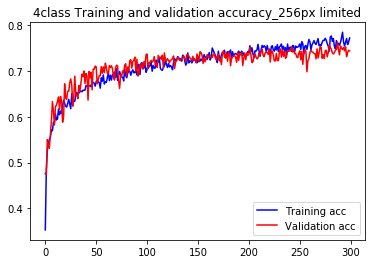

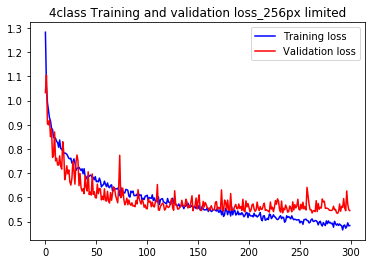

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('4class Training and validation accuracy_256px limited')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('4class Training and validation loss_256px limited')
plt.legend()

plt.show()

#### テストデータセットによる精度評価

In [8]:
metric = model.evaluate_generator(test_generator)
print('Test loss = ', metric[0])
print('Test acc  = ', metric[1])

Test loss =  0.514887398481369
Test acc  =  0.736875006556511


#### テストデータセットからサンプリングした銀河イメージデータについての形態クラス予測結果

{'Edgeon': 0, 'En': 1, 'S': 2, 'SB': 3}
Edgeon_6_9_49_587732153640878196.jpeg
Edgeon : 97%   SB : 2%   S : 0%   En : 0%   


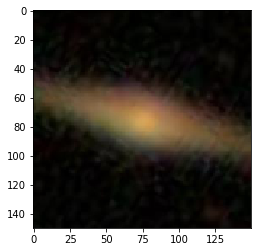

Edgeon_5_11_60_588017627783168157.jpeg
Edgeon : 99%   SB : 0%   S : 0%   En : 0%   


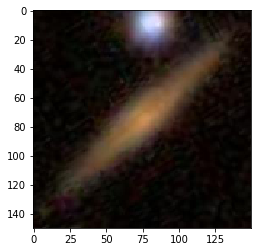

Edgeon_7_3_59_587736618786685221.jpeg
Edgeon : 99%   SB : 0%   S : 0%   En : 0%   


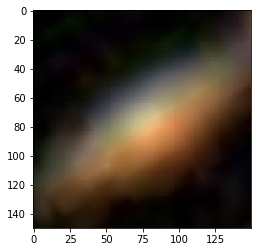

Edgeon_7_7_46_588010879836684299.jpeg
SB : 37%   S : 34%   Edgeon : 27%   En : 0%   


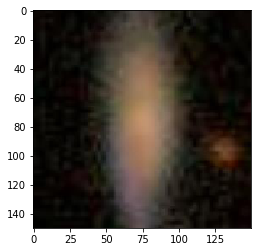

Edgeon_5_5_56_587739505011261584.jpeg
Edgeon : 99%   S : 0%   SB : 0%   En : 0%   


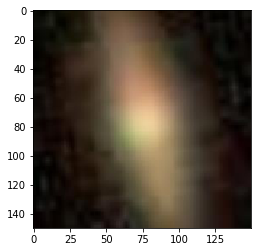

Edgeon_6_5_57_587722983910277504.jpeg
Edgeon : 93%   S : 3%   SB : 3%   En : 0%   


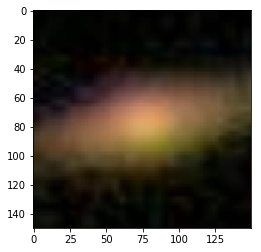

Edgeon_6_10_60_587731869624500377.jpeg
Edgeon : 95%   SB : 3%   S : 0%   En : 0%   


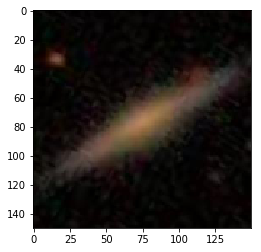

Edgeon_7_4_52_587739707416444994.jpeg
Edgeon : 98%   S : 0%   SB : 0%   En : 0%   


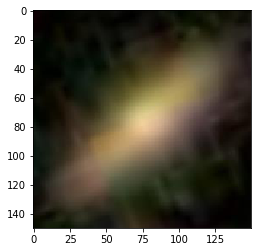

Edgeon_7_14_51_588017979449868512.jpeg
Edgeon : 74%   SB : 20%   S : 4%   En : 0%   


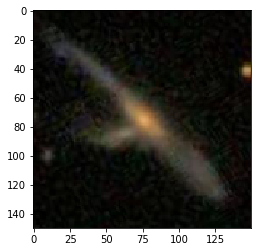

Edgeon_7_10_37_587739407840641126.jpeg
Edgeon : 98%   SB : 1%   S : 0%   En : 0%   


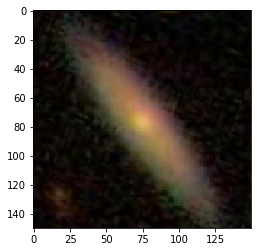

En_5_5_46_587745244702048337.jpeg
En : 99%   SB : 0%   S : 0%   Edgeon : 0%   


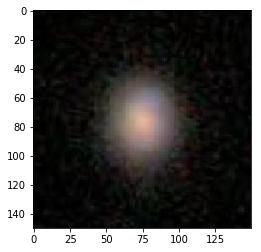

En_4_6_53_587741710492434536.jpeg
En : 99%   SB : 0%   S : 0%   Edgeon : 0%   


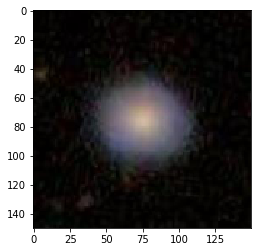

En_6_6_55_587732153640353960.jpeg
En : 99%   SB : 0%   S : 0%   Edgeon : 0%   


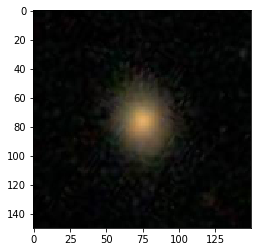

En_4_7_50_587725469055844591.jpeg
En : 99%   S : 0%   SB : 0%   Edgeon : 0%   


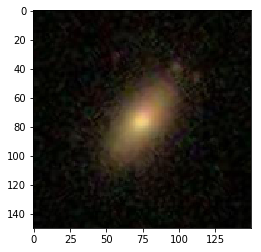

En_7_9_57_587738617555386414.jpeg
En : 99%   SB : 0%   S : 0%   Edgeon : 0%   


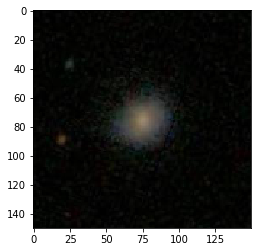

En_2_9_46_587726031704948739.jpeg
En : 79%   S : 14%   SB : 5%   Edgeon : 0%   


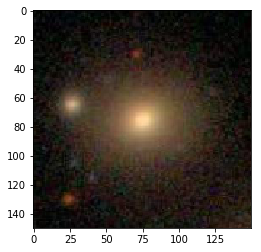

En_6_10_41_587724649792340174.jpeg
En : 99%   S : 0%   SB : 0%   Edgeon : 0%   


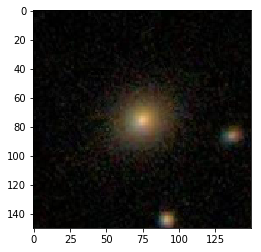

En_7_6_45_587738947747709157.jpeg
En : 99%   S : 0%   SB : 0%   Edgeon : 0%   


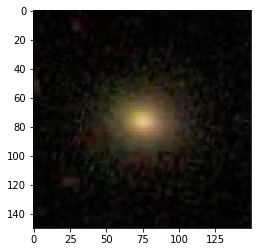

En_4_10_40_588010136802689224.jpeg
En : 99%   S : 0%   SB : 0%   Edgeon : 0%   


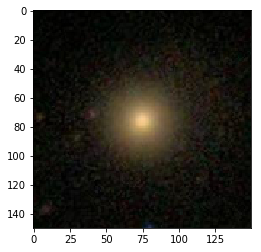

En_3_16_34_587733399708369014.jpeg
En : 98%   S : 0%   SB : 0%   Edgeon : 0%   


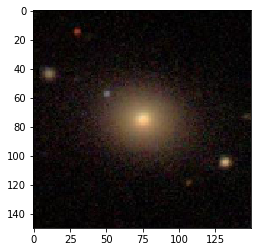

S_5_14_32_587739505005887631.jpeg
S : 64%   SB : 30%   En : 3%   Edgeon : 1%   


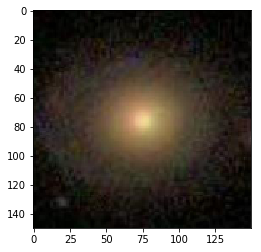

S_2_20_40_588848900436525204.jpeg
SB : 53%   S : 46%   Edgeon : 0%   En : 0%   


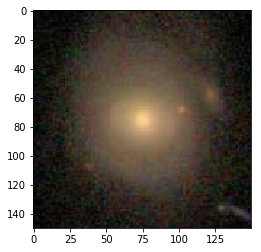

S_7_6_60_587728307488293001.jpeg
SB : 51%   S : 48%   Edgeon : 0%   En : 0%   


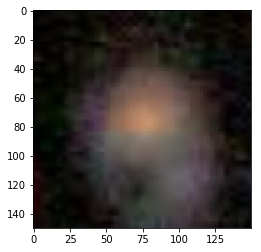

S_7_7_41_588017704557215973.jpeg
S : 74%   SB : 23%   Edgeon : 1%   En : 0%   


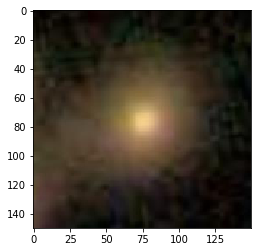

S_7_8_52_588017721180815456.jpeg
S : 73%   SB : 26%   Edgeon : 0%   En : 0%   


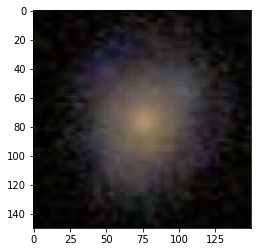

S_7_6_50_587729233051255070.jpeg
SB : 52%   S : 47%   Edgeon : 0%   En : 0%   


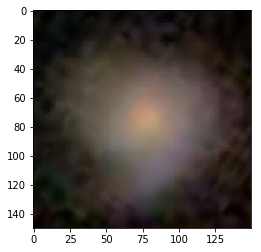

S_7_8_54_587730022519668950.jpeg
S : 70%   SB : 23%   En : 4%   Edgeon : 2%   


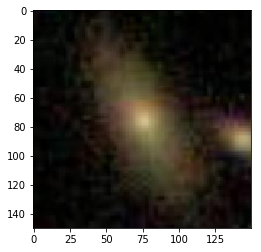

S_6_6_48_587734623782043805.jpeg
S : 64%   SB : 35%   Edgeon : 0%   En : 0%   


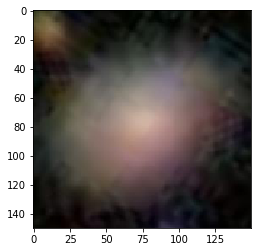

S_6_7_59_587734893285867599.jpeg
SB : 43%   S : 30%   Edgeon : 25%   En : 0%   


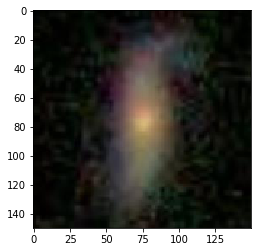

S_7_8_44_588017947218542795.jpeg
SB : 50%   S : 42%   Edgeon : 6%   En : 0%   


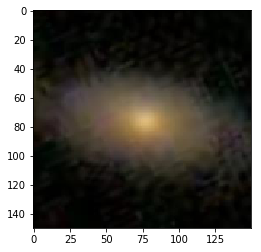

SB_7_8_43_587736809916399788.jpeg
SB : 91%   S : 8%   Edgeon : 0%   En : 0%   


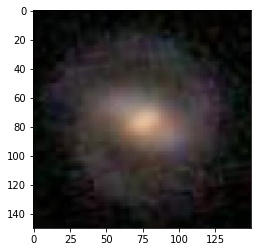

SB_5_9_39_587741817321029713.jpeg
S : 57%   SB : 42%   En : 0%   Edgeon : 0%   


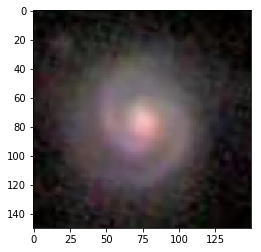

SB_7_8_40_587739132428943405.jpeg
Edgeon : 45%   SB : 32%   S : 21%   En : 0%   


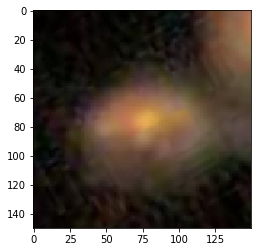

SB_3_13_45_587739506623840446.jpeg
SB : 69%   S : 30%   Edgeon : 0%   En : 0%   


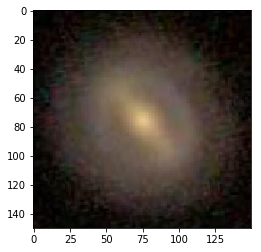

SB_3_9_59_587742865278959753.jpeg
S : 59%   SB : 40%   Edgeon : 0%   En : 0%   


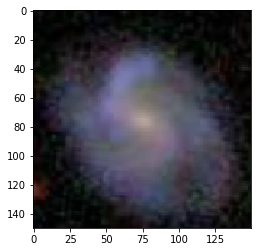

SB_7_5_52_587732134311821377.jpeg
S : 53%   SB : 42%   Edgeon : 4%   En : 0%   


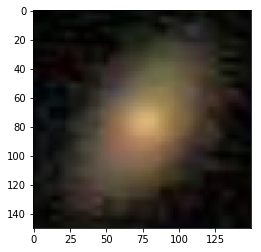

SB_7_5_57_587742902863921328.jpeg
SB : 66%   S : 32%   Edgeon : 0%   En : 0%   


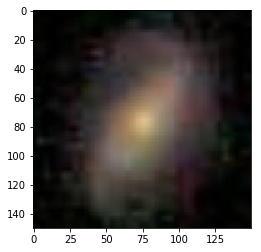

SB_3_12_56_587742062677459114.jpeg
SB : 77%   S : 22%   Edgeon : 0%   En : 0%   


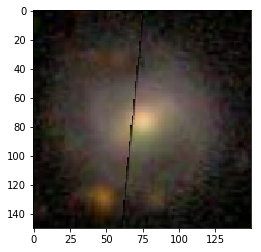

SB_5_9_59_587736897965785436.jpeg
SB : 70%   S : 25%   Edgeon : 3%   En : 0%   


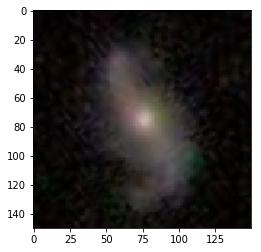

SB_7_9_44_587728918984261783.jpeg
SB : 67%   S : 30%   Edgeon : 2%   En : 0%   


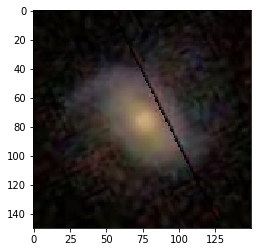

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

#クラス予測サンプリング数
sample_size = 10

class_indices_dict = test_generator.class_indices
print(class_indices_dict)

class_list = list(class_indices_dict.keys())

for class_name in class_list:
    prediction_fnames_series = pd.Series(np.array(os.listdir(test_generator_directory + '/' + class_name)))
    prediction_fnames_selected = prediction_fnames_series.sample(n=sample_size).values
    
    for prediction_fname in prediction_fnames_selected:
        print(prediction_fname)
        prediction_img = load_img(test_generator_directory + '/' + class_name + '/' + prediction_fname, target_size = (150,150))
        prediction_arr = img_to_array(prediction_img)
        prediction_arr /= 255.0
        input_arr = prediction_arr.reshape(1,150,150,3)
        probs = model.predict(input_arr)[0]
        probs_series_sorted = pd.Series(probs, index = class_list).sort_values(ascending=False)
        #print(probs_series_sorted.index)
        #print(probs_series_sorted)
        prediction_results = ''
        for class_index in probs_series_sorted.index:
            prediction_results += class_index + ' : ' + str(int(probs_series_sorted[class_index] * 100)) + '%' + '   ' 
            #prediction_results_list = prediction_results_list.append(prediction_results)                                             
            
        print(prediction_results)                                              
        plt.imshow(input_arr[0])
        plt.show()
        